In [11]:
import numpy as np 
import matplotlib.pyplot as plt 
from sunRay.parameters import c,c_r,R_S  # physics parameters
from scipy import integrate

In [12]:
%load_ext autoreload
%autoreload 2
%load_ext autotime

In [13]:
#data  = np.load('sunray_small_float32_20deg_0.3_0.1.npz')#'sunray_big_float32_20deg.npz')#'sunray_float32_20deg_small.npz')
data  = np.load('../RUN_[eps0.25829]_[alpha0.41].npz')
#data  = np.load('../RUN_[eps0.5]_[alpha0.95].npz')

time: 3 ms


In [14]:
absorb_r = (np.count_nonzero((np.isnan(data.f.r_vec_collect_local[-1,1,:]))))/data.f.photon_N

time: 2.7 s


In [16]:
# retrive the data from archive
steps_N  =data.f.steps_N
collect_N =data.f.collect_N
photon_N =data.f.photon_N
start_r =data.f.start_r
start_theta =data.f.start_theta
start_phi  =data.f.start_phi
f_ratio  =data.f.f_ratio
epsilon =data.f.epsilon 
anis =data.f.anis
asym =data.f.asym
omega0 = data.f.omega0
freq0 = data.f.freq0
t_collect=data.f.t_collect
tau=data.f.tau
r_vec_collect_local=data.f.r_vec_collect_local
k_vec_collect_local=data.f.k_vec_collect_local
tau_collect_local = data.f.tau_collect_local

time: 5.8 s


In [17]:
np.argmin(np.abs(np.nanmin((np.sqrt(np.sum(r_vec_collect_local**2,axis=1))),axis=1)-15))/180*27000
steps_N

array([21910.021], dtype=float32)

time: 500 ms


[ 1.9634037e-05 -6.4241147e-05  1.7501285e+00]


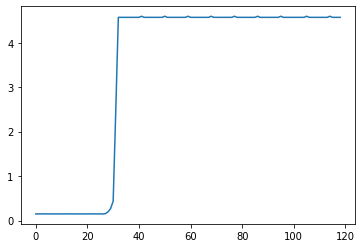

time: 261 ms


In [7]:
plt.plot(np.diff(t_collect))
print(r_vec_collect_local[0,:,7])

In [14]:
r_vec_collect_local.shape

(120, 3, 200000)

time: 3 ms


In [18]:
from sunRay.statisticalRays import reduct_lv2,centroidXYFWHM, variationXYFWHM,FWHM

(x_im_stat,y_im_stat,t_reach_1au_stat,weights_stat,t_free_stat) = reduct_lv2(photon_N,r_vec_collect_local,k_vec_collect_local,t_collect,tau_collect_local,omega0)

(xc,yc,sx,sy,err_xc,err_yc,err_sx,err_sy) = centroidXYFWHM(
    x_im_stat,y_im_stat,weights_stat)


# to be finished extract useful information

time: 18.5 s


In [12]:

(t_bin_center,flux_all,xc_all,yc_all,sx_all,sy_all,err_xc_all,err_yc_all,
        err_sx_all,err_sy_all) = variationXYFWHM(x_im_stat,y_im_stat,t_reach_1au_stat,weights_stat,num_t_bins=100)

FWHM_range = FWHM(t_bin_center,flux_all)
duration_cur  =  FWHM_range[1]-FWHM_range[0]

time: 47.5 ms


In [21]:
import sunRay.statisticalRays as raystat 

time: 1.03 ms


In [22]:
(r_vec_stat_avail,k_vec_stat_avail,t_reach_stat_avail,tau_stat_avail,
            r_vec_0, k_vec_0) =  raystat.reduct_lv1(
                photon_N,r_vec_collect_local,k_vec_collect_local,
                t_collect,tau_collect_local,omega0,num_t_bins=60)

time: 17.1 s


In [16]:
(x_im_stat,y_im_stat,t_reach_1au_stat,weights_stat,t_free_stat
)=raystat.reduct_lv2(photon_N,r_vec_collect_local,k_vec_collect_local,
t_collect,tau_collect_local,omega0,num_t_bins=60)

time: 17.1 s


In [19]:
(x_im_stat,y_im_stat,t_reach_1au_stat,weights_stat,t_free_stat)=raystat.ImgXYtEstimate(r_vec_stat_avail,k_vec_stat_avail,t_reach_stat_avail,
            tau_stat_avail,r_vec_0, k_vec_0,num_t_bins=60)

time: 1.53 s


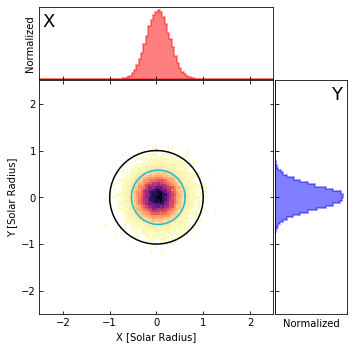

time: 912 ms


In [20]:
#hst = plt.hist2d(x_im_stat,y_im_stat,bins=[np.linspace(-2,2,100),np.linspace(-2,2,100)],weights=np.exp(-tau_stat))
#plt.axis('equal')


from sunRay.showPlot import XYDistributionImageHist

XYDistributionImageHist(x_im_stat,y_im_stat,bins_data=np.linspace(-2.5,2.5,100)
            ,weights_data=weights_stat)

0.410542449947336


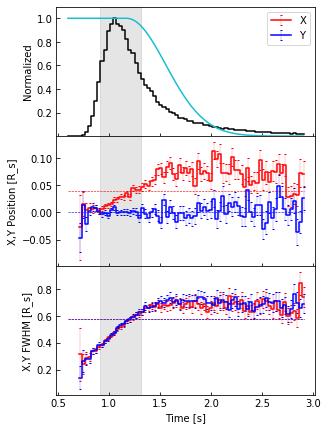

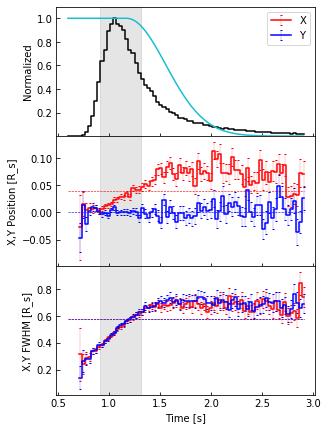

time: 2.63 s


In [21]:
from sunRay.showPlot import XYVariationPlot

XYVariationPlot(x_im_stat,y_im_stat,t_reach_1au_stat,weights_stat,t_step = 0.03)

In [27]:
hst = plt.hist(t_reach_1au_stat,150,weights=np.exp(-tau_stat))


In [47]:
215/c_r

499.13275517011346

In [145]:
print(hst[0][20,:])

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 5.22065742e-01 0.00000000e+00 4.40566029e-01 1.70077755e+00
 1.70748397e+00 6.95538646e+00 5.89382475e+00 9.85790884e+00
 1.26816283e+01 2.18808190e+01 2.89920703e+01 4.33193431e+01
 6.20829333e+01 6.96648978e+01 8.87157899e+01 8.75351301e+01
 1.02120347e+02 1.11840275e+02 1.07779498e+02 1.13492928e+02
 1.17933382e+02 1.16222340e+02 1.07980399e+02 9.12755591e+01
 8.95812356e+01 8.26491111e+01 7.54039651e+01 5.97456903e+01
 4.14483934e+01 3.11447867e+01 2.23753065e+01 1.72361751e+01
 1.14423529e+01 2.51488231e+00 1.75856313e+00 1.58451947e+00
 4.89390125e-01 7.68808850e-01 2.72333048e-01 0.00000000e+00
 1.13675706e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.60123366e-01 0.00000000e+00]


In [88]:
x_im_stat.shape
# finish time diff based 
# fit guassian

(217062,)

In [4]:
import sunRay_v0 as sr
import numpy as np
arr_eps   = np.linspace(0.03,0.5,20)
arr_alpha = np.linspace(0.05,0.95,20)

res = sr.run_parset(arr_eps, arr_alpha)

Proc : 1 of 20


In [15]:
np.mean(r_vec_collect_local)

array([[ 50.10711  ,   1.3218341,  20.082058 , ...,   5.1332364,
                nan,  46.651756 ],
       [ -7.4703374, -21.20062  ,  12.607695 , ..., -18.445623 ,
                nan, -25.699118 ],
       [ 45.88431  ,  64.44606  ,  64.07608  , ...,  65.962296 ,
                nan,  42.911858 ]], dtype=float32)

In [5]:
arr_eps[9]

0.25263157894736843

In [ ]:
np.savez('parset.npz',res)

In [8]:
88*c_r

37.90574712643678

In [23]:
r=0.95

0.1+4*r,  0.1+r**0.5

(3.9, 1.0746794344808963)

In [50]:
import numpy as np
data_par  = np.load('parset.npz')

time: 2 ms


In [51]:
res = data_par.f.arr_0

time: 2 ms


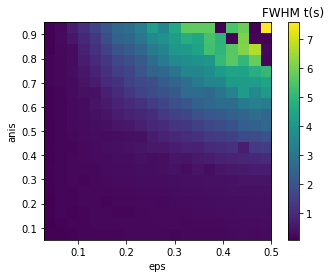

time: 480 ms


In [52]:

arr_eps   = np.linspace(0.03,0.5,20)    
arr_alpha = np.linspace(0.05,0.95,20)

plt.imshow(res[0].T,origin='lower',extent=[np.min(arr_eps),np.max(arr_eps),np.min(arr_alpha),np.max(arr_alpha)])
cbar = plt.colorbar()
cbar.ax.set_title('FWHM t(s)')

ax = plt.gca()
ax.set_xlabel('eps')
ax.set_ylabel('anis')

ax.set_aspect(1/2)
#plt.gca().set_xticks(range(len(arr_eps)))
#plt.gca().set_yticks(range(len(arr_eps)))
#plt.gca().set_yticklabels(arr_alpha)
#plt.gca().set_xticklabels(np.round(arr_eps*100))

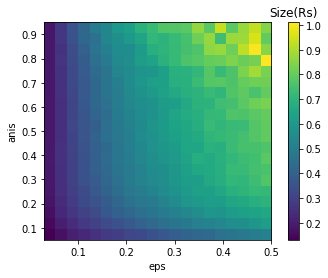

time: 491 ms


In [53]:
plt.close('all')

plt.imshow(res[1].T, origin='lower', extent=[np.min(arr_eps),np.max(arr_eps),np.min(arr_alpha),np.max(arr_alpha)])
cbar = plt.colorbar()
cbar.ax.set_title('Size(Rs)')

ax = plt.gca()
ax.set_xlabel('eps')
ax.set_ylabel('anis')
ax.set_aspect(1/2)

In [11]:
#single test


data  = np.load('datatmp/RUN_[eps0.5]_[alpha0.95].npz')


steps_N  =data.f.steps_N
collect_N =data.f.collect_N
photon_N =data.f.photon_N
start_r =data.f.start_r
start_theta =data.f.start_theta
start_phi  =data.f.start_phi
f_ratio  =data.f.f_ratio
epsilon =data.f.epsilon 
anis =data.f.anis
asym =data.f.asym
omega0 = data.f.omega0
freq0 = data.f.freq0
t_collect=data.f.t_collect
tau=data.f.tau
r_vec_collect_local=data.f.r_vec_collect_local
k_vec_collect_local=data.f.k_vec_collect_local
tau_collect_local = data.f.tau_collect_local

time: 2.39 s


In [12]:

import sunRay.statisticalRays as raystat

(x_im_stat,y_im_stat,t_reach_1au_stat,weights_stat,t_free_stat
        ) = raystat.collectXYtatR(photon_N,r_vec_collect_local,
        k_vec_collect_local,t_collect,tau_collect_local,omega0)

(xc,yc,sx,sy,err_xc,err_yc,err_sx,err_sy) = raystat.centroidXYFWHM(
        x_im_stat,y_im_stat,weights_stat)

(t_bin_center,flux_all,xc_all,yc_all,sx_all,sy_all,err_xc_all,err_yc_all,
        err_sx_all,err_sy_all) = raystat.variationXYFWHM(x_im_stat,y_im_stat,
        t_reach_1au_stat,weights_stat,num_t_bins=60)


FWHM_range = raystat.FWHM(t_bin_center,flux_all)


IndexError: index 58 is out of bounds for axis 0 with size 1

0.4581433531204512


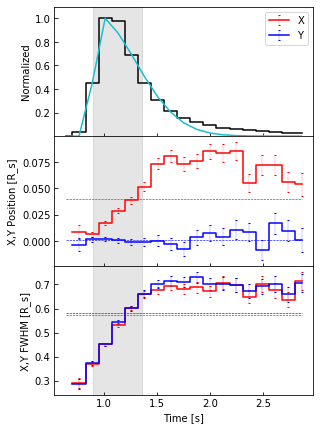

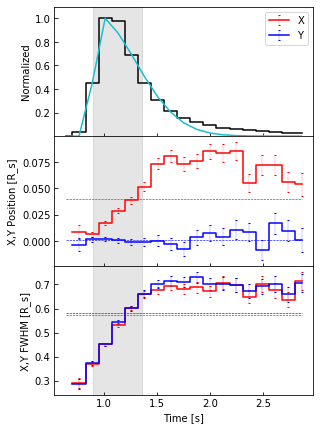

time: 2.14 s


In [13]:
from sunRay.showPlot import XYVariationPlot
XYVariationPlot(x_im_stat,y_im_stat,t_reach_1au_stat,weights_stat,num_t_bins=20)

In [62]:
t_reach_1au_stat.shape

(146,)

time: 3.01 ms


In [10]:
r_vec_collect_local[-1,:,:]

array([[ 121.01916 ,  -60.02821 ,   75.40926 , ...,    5.955928,
         -83.33347 ,   19.183483],
       [  20.825205,   69.52936 ,  -59.05248 , ..., -128.23021 ,
          21.963173,   52.051132],
       [ 125.11414 ,  149.4002  ,  146.86736 , ...,  119.01273 ,
         152.77402 ,  166.87857 ]], dtype=float32)

time: 4 ms


In [7]:
from mpl_toolkits import mplot3d

time: 14 ms


In [32]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

time: 2.03 ms


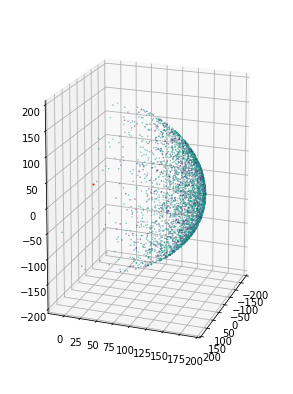

time: 2.39 s


In [84]:
fig = plt.figure(figsize=[5,7])
ax = plt.axes(projection='3d')

ax.scatter(r_vec_stat_avail[1,0:4000],r_vec_stat_avail[2,0:4000],r_vec_stat_avail[0,0:4000],c=np.exp(-tau_stat_avail)[0:4000],s=0.1, vmax=1,vmin=0,alpha=0.9)

ax.scatter(0,0,0,c='red',s=1)

ax.set_xlim([-200, 200])
ax.set_ylim([-20, 200])
ax.set_zlim([-200, 200])

ax.view_init(elev=15, azim=20)

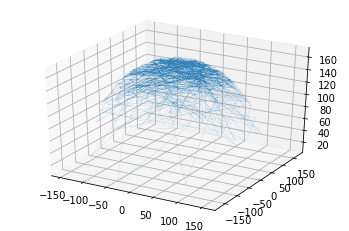

time: 366 ms


In [53]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(r_vec_stat_avail[0,0:500],r_vec_stat_avail[1,0:500],r_vec_stat_avail[2,0:500],alpha=0.9,linewidth=0.1)

In [23]:
import plotly.graph_objects as go
import numpy as np

# Helix equation
t = np.linspace(0, 10, 50)
x, y, z = np.cos(t), np.sin(t), t

fig = go.Figure(data=[go.Scatter3d(x=r_vec_stat_avail[0,0:500],
            y=r_vec_stat_avail[1,0:500],z=r_vec_stat_avail[2,0:500],
                                   mode='markers',
            marker=dict(size=1))])

fig.show()

time: 24.1 ms


In [24]:
go.Scatter3d(x=r_vec_stat_avail[0,0:500],
            y=r_vec_stat_avail[1,0:500],z=r_vec_stat_avail[2,0:500],
                                   mode='markers',
            marker=dict(size=1))

Scatter3d({
    'marker': {'size': 1},
    'mode': 'markers',
    'x': array([118.58743286, -58.79601669,  73.87402344, ..., -89.57148743,
                -81.56842041,  58.21259308]),
    'y': array([ 20.40351486,  68.10006714, -57.84388733, ..., -20.68927383,
                 28.23414612,  14.69595814]),
    'z': array([122.64006805, 146.37376404, 143.93255615, ..., 145.15087891,
                148.55738831, 160.98196411])
})

time: 23 ms
